## Goal

* use the mathematical formulation of the optimization task,
* formulate the indicator function and explain how it relates to the outcome
of the classification,
* predict and explain the outcome of using different kernels,
* explain the effect of the C-value when using slack variables.

In [1]:
import numpy as np, random, math, scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
k_linear = lambda x, y: np.inner(x, y)

In [3]:
def objective(inner, a):
    return (.5 * a * a.reshape(-1, 1) * inner).sum() - a.sum()

In [4]:
def zerofun(t, a):
    return np.dot(a, t)

In [5]:
from functools import partial

In [6]:
def calc(k, x, t, c=1):
    N = len(x)
    start = np.zeros(N)
    bounds=[(0, c) for b in range(N)]
    constraint={'type':'eq', 'fun': partial(zerofun, t)}
    p = np.multiply(np.einsum('i,j->ij', t, t), np.array([[k(m, n) for m in x] for n in x]))
    cached_obj = partial(objective, p)
    return minimize(cached_obj, start, bounds=bounds, constraints=constraint)

In [7]:
np.random.seed(100)
class_a = np.concatenate((np.random.randn(10, 2) * 0.2 + [1.5, 0.5], np.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))
class_b = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]
inputs = np.concatenate((class_a, class_b))
targets = np.concatenate((np.ones(class_a.shape[0]), -np.ones(class_b.shape[0])))
N = inputs.shape[0]
permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

(-1.9463741582865122,
 1.9057015090269784,
 -0.9293661327123232,
 0.8910680428843483)

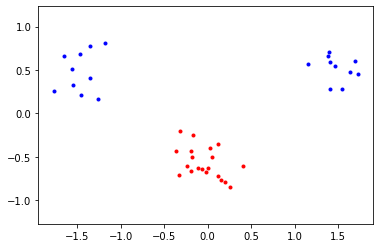

In [8]:
plt.plot([p[0] for p in class_a], [p[1] for p in class_a], 'b.')
plt.plot([p[0] for p in class_b], [p[1] for p in class_b], 'r.')
plt.axis('equal')

In [9]:
res = calc(k_linear, inputs, targets, c=None)
res

     fun: -12.040386129125663
     jac: array([ 2.67725325,  2.89897609,  1.5463295 ,  2.40684378,  0.75528932,
        2.05285048,  0.34154582,  0.07834148,  3.20548701,  1.44818759,
        1.05967915,  1.5828352 ,  2.08386803,  1.0062989 ,  2.07686996,
       -0.0583663 ,  0.05837488,  0.05865955,  2.11342573,  0.95056498,
        1.94074452,  1.96238077,  1.28751218,  0.84099865,  2.22393525,
        3.20987749,  2.16894174,  2.32062674,  0.61446297,  1.39490473,
        1.83437133,  0.95810556,  1.59998238,  0.1901015 ,  2.76461005,
        1.01527584,  1.39623153,  2.59843075,  3.0705688 ,  2.55894315])
 message: 'Optimization terminated successfully.'
    nfev: 968
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.25399439e-15, 0.00000000e+00, 0.00000000e+00, 1.00889907e-14,
       0.00000000e+00, 1.61430599e-15, 1.89670512e-14, 0.00000000e+00,
       0.00000000e+00, 2.63526889e-15, 0.00

In [10]:
a = res['x']
indices = np.where(a > 10**-5)
a[a < 10**-5] = 0

In [11]:
ai = a[indices]
xi = inputs[indices]
ti = targets[indices]
ai

array([12.04102503,  7.89021559,  4.15080944])

In [24]:
b = (ai * ti * [k_linear(xi[0], x) for x in xi]).sum() - ti[0]
b

0.05836649402964156

In [25]:
def indicator(x, y):
    return (ai * ti * np.array([k_linear(np.array([x, y]), p) for p in xi])).sum() - b

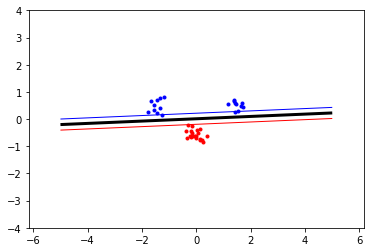

In [31]:
plt.plot([p[0] for p in class_a], [p[1] for p in class_a], 'b.')
plt.plot([p[0] for p in class_b], [p[1] for p in class_b], 'r.')
xgrid=np.linspace(-5, 5)
ygrid=np.linspace(-4, 4)
grid = np.array([[indicator(x, y) for x in xgrid] for y in ygrid])
plt.axis('equal')
plt.contour(xgrid, ygrid, grid, (-1, 0, 1), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))